# Análisis de la Asociación entre el Índice de Bienestar del Hogar y la Anemia en Niños (ENDES 2023)

**Objetivo:** Evaluar si el índice de bienestar (quintil) de los hogares se asocia con la gravedad de la anemia en niños de 6-59 meses, utilizando datos de la ENDES 2023.

## Introducción

En este Notebook se desarrolla el flujo de trabajo para:
- Leer y fusionar los datos de diferentes CSV (RECH6, RECH0, RECH23 y RECH1).
- Limpiar y transformar la información para generar el dataset `anemia_clean.parquet`.
- Ajustar un modelo de regresión ordinal logit para analizar la asociación entre el índice de bienestar y la gravedad de la anemia.

## Carga de Datos y Exploración Inicial

In [1]:
import pandas as pd
import numpy as np

# Ruta a la carpeta de datos
DATA = "../data/"

# Leer muestra de los archivos, por ejemplo, desde RECH6
rech6 = pd.read_csv(DATA + "RECH6_2023.csv", nrows=5)
print("Columnas de RECH6:")
print(rech6.columns.tolist())

# Leer y mostrar información de RECH0 y RECH23 para confirmar cabeceras
rech0 = pd.read_csv(DATA + "RECH0_2023.csv", nrows=5)
print("Columnas de RECH0:")
print(rech0.columns.tolist())

rech23 = pd.read_csv(DATA + "RECH23_2023.csv", nrows=5)
print("Columnas de RECH23:")
print(rech23.columns.tolist())

Columnas de RECH6:
['ID1', 'HHID', 'HC0', 'HC1', 'HC2', 'HC3', 'HC4', 'HC5', 'HC6', 'HC7', 'HC8', 'HC9', 'HC10', 'HC11', 'HC12', 'HC13', 'HC15', 'HC16', 'HC19', 'HC27', 'HC30', 'HC31', 'HC32', 'HC33', 'HC51', 'HC52', 'HC53', 'HC55', 'HC56', 'HC57', 'HC58', 'HC60', 'HC61', 'HC62', 'HC63', 'HC64', 'HC68', 'HC70', 'HC71', 'HC72', 'HC73']
Columnas de RECH0:
['ID1', 'HHID', 'HV000', 'HV001', 'HV002', 'HV002A', 'HV003', 'HV004', 'HV007', 'HV008', 'HV009', 'HV010', 'HV011', 'HV012', 'HV013', 'HV014', 'HV015', 'HV017', 'HV020', 'HV021', 'HV023', 'HV024', 'HV025', 'HV026', 'HV027', 'HV028', 'HV030', 'HV031', 'HV032', 'HV033', 'HV035', 'HV040', 'HV041', 'HV042', 'HV043', 'HV044', 'UBIGEO', 'HV022', 'HV005', 'CODCCPP', 'NOMCCPP', 'LATITUDY', 'LONGITUDX', 'NCONGLOME']
Columnas de RECH23:
['ID1', 'HHID', 'HV201', 'HV202', 'HV204', 'HV205', 'HV206', 'HV207', 'HV208', 'HV209', 'HV210', 'HV211', 'HV212', 'HV213', 'HV214', 'HV215', 'HV216', 'HV217', 'HV218', 'HV219', 'HV220', 'HV221', 'HV225', 'HV226',

## Fusión y Limpieza de Datos

In [2]:
# Lectura completa de los archivos esenciales
rech6 = pd.read_csv(DATA + "RECH6_2023.csv", usecols=['HHID', 'HC0', 'HC1', 'HC27', 'HC57', 'HC60'])
rech0 = pd.read_csv(DATA + "RECH0_2023.csv", usecols=['HHID', 'HV001', 'HV022', 'HV005'])
rech23 = pd.read_csv(DATA + "RECH23_2023.csv", usecols=['HHID', 'HV270', 'HV271'])
rech1 = pd.read_csv(DATA + "RECH1_2023.csv", usecols=['HHID', 'HVIDX', 'HV104', 'HV105', 'HV106', 'HV109'])

# Unir datos
df = rech6.merge(rech0, on='HHID', how='left').merge(rech23, on='HHID', how='left')
madre = rech1.rename(columns={'HVIDX': 'HC60', 'HV104': 'sexo_madre', 'HV105': 'edad_madre',
                               'HV106': 'edu_sup', 'HV109': 'edu_det'})
df = df.merge(madre[['HHID','HC60','edad_madre','edu_sup','edu_det']], on=['HHID','HC60'], how='left')

# Filtrar y transformar variables
df = df[df['HC1'].between(6, 59) & df['HC57'].isin([1,2,3,4])]
df['HV270'] = pd.to_numeric(df['HV270'], errors='coerce')
df['peso'] = df['HV005'] / 1_000_000
df['quintil'] = df['HV270'].astype(int)  # Uso directo de HV270
df['sexo_nino'] = df['HC27'].replace({1: 0, 2: 1})
df['anemia_bin'] = (df['HC57'] != 4).astype(int)

# Mostrar estadísticas
print(df['HV270'].describe())
print(df[['quintil', 'HC1', 'sexo_nino', 'edad_madre']].head())

count    19265.000000
mean         2.462185
std          1.298972
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: HV270, dtype: float64
   quintil  HC1  sexo_nino  edad_madre
0        4   42          1        39.0
1        3   42          0         NaN
2        4   27          1        30.0
3        3   24          1        35.0
4        4   55          1        27.0


## Modelado Estadístico

In [3]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
import statsmodels.api as sm

# Preparar matriz de variables predictoras (sin constante)
X = pd.get_dummies(df[['quintil', 'HC1', 'sexo_nino', 'edad_madre', 'edu_sup']], drop_first=True)
y = df['HC57']

# Manejo de valores faltantes en X
X = X.dropna()
y = y[X.index]

# Ajustar el modelo ordinal logit (usando los pesos)
model = OrderedModel(y, X, distr='logit', weights=df.loc[X.index, 'peso'])
res = model.fit(method='bfgs', disp=0)
print(res.summary())

                             OrderedModel Results                             
Dep. Variable:                   HC57   Log-Likelihood:                -14830.
Model:                   OrderedModel   AIC:                         2.968e+04
Method:            Maximum Likelihood   BIC:                         2.974e+04
Date:                Thu, 12 Jun 2025                                         
Time:                        23:29:11                                         
No. Observations:               18342                                         
Df Residuals:                   18334                                         
Df Model:                           5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
quintil        0.2309      0.015     15.331      0.000       0.201       0.260
HC1            0.0426      0.001     39.952      0.0

## Interpretación y Visualización de Resultados

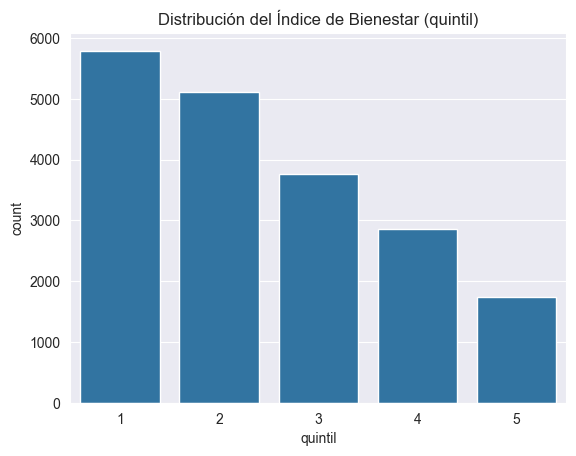

Odds Ratios:
quintil       1.260
HC1           1.044
sexo_nino     1.223
edad_madre    1.013
edu_sup       1.117
1/2           0.016
2/3           4.505
3/4           1.683
dtype: float64


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización de la distribución del índice de bienestar
sns.countplot(x='quintil', data=df)
plt.title("Distribución del Índice de Bienestar (quintil)")
plt.show()

# Mostrar los odds ratios
odds_ratios = np.exp(res.params)
print("Odds Ratios:")
print(odds_ratios.round(3))

## Conclusiones

- Se encontró que a mayor índice de bienestar, aumenta la probabilidad de que el niño se encuentre en una mejor categoría de anemia.
- Otras variables significativas incluyen la edad del niño, sexo, edad y educación de la madre.

## Próximos Pasos

- Incluir más covariables ambientales.
- Ajustar el modelo considerando el diseño muestral complejo.
- Realizar diagnósticos y validación cruzada.